# Underfitting and Overfitting

Welcome! This workshop is from [TrainingDataScience.com](https://trainingdatascience.com/?utm_source=trainingdatascience&utm_medium=notebook&utm_campaign=workshop&utm_term=individual). Sign up to receive more free workshops, training and videos.

Imagine you had developed a model that predicts some output. The goal of any model is to generate a correct prediction and avoid incorrect predictions. But how can we be sure that predictions are as good as they can possibly be?

Now constrain your imagining to a classification task (other tasks have similar properties but I find classification easiest to reason about). We use some data to train the model. The result of the training process will be a decision boundary. I.e. class A on one side, class B on another.

We've already seen from our [data processing workshop](https://trainingdatascience.com/workshops/histograms-and-skewed-data/) ([members](https://trainingdatascience.com/join/) have further [data processing workshops](https://trainingdatascience.com/workshops/)) that data is noisy. If we're not careful, we will end up fitting the noise, not the underlying process. In other words our model would be trained to classify based upon the presence of the noise, rather than the underlying signal. This is bad and is called overfitting. Often you will see good training results and poor real-life/production results.

The opposite problem is the signal, the representation of the underlying process, is quite complicated. For example, maybe your data isn't seperable with a linear model. If you tried to use a simple model such as this you might see similar levels of poor performance in both training and real-life production. This is called underfitting.

In reality, underfitting is probably better than overfitting, because at least your model is performing to some expected standard. The worst case scenario is when you tell your boss you have an amazing new model that will change the world, only for it to crash and burn in production!

This workshop is an introduction to under and overfitting.

In [1]:
# Usual imports
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display

## Plotting Under and Overfitting

First we're going to generate some complex two-dimensional data. This allows us to be able to plot the data easily whilst making the data complex enough to show the effects of under and overfitting. These data are two concentric circles; i.e. one circle within another.

In [2]:
from sklearn.datasets import make_circles

# Synthetic data
X, y = make_circles(noise=0.2, factor=0.5, random_state=1)

First I want to show you the decision boundaries generated by under and overfitting models. This should give you some visual intuition as to what I mean by a "complex decision boundary".

To do this I'm going to use an SVM with a radial basis function. Check out the [workshop on SVMs](http://members.trainingdatascience.com/workshops/classification/) if you haven't come across this before. The good think about the RBF version of a SVM is that we can use the size of the RBF to simulate simple and complex decision boundaries.

In [3]:
from sklearn.svm import SVC

classifiers = [        # Three different SVM classifiers with difference values of gamma.
    SVC(gamma=0.001),
    SVC(gamma=1),
    SVC(gamma=20)]
names = ["SVM (rbf, $\gamma = 0.001$)", "SVM (rbf, $\gamma = 1$)", "SVM (rbf, $\gamma = 20$)"]

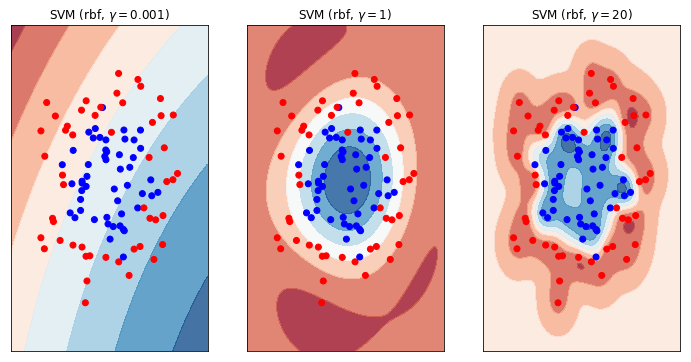

In [4]:
from matplotlib.colors import ListedColormap

figure = plt.figure(figsize=(12, 6))
i = 1
h = .02  # step size in the mesh
x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])

# iterate over classifiers
for name, clf in zip(names, classifiers):
    ax = plt.subplot(1, len(classifiers), i)
    clf.fit(X, y)

    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
    if hasattr(clf, "decision_function"):
        Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
    else:
        Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    ax.contourf(xx, yy, Z, cmap=cm, alpha=.8)

    ax.scatter(X[:, 0], X[:, 1], c=y, cmap=cm_bright)

    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_title(name)
    i += 1
plt.show()

Let me explain the plot above. The data comrpises of two classes, blue and red. There are contour plots shown on top of the scatter plots which show the decision boundary for our trained SVM model. Where the contour is red we will predict red. Where the contour is blue, predict blue. White means there is a 50/50 chance of either class (i.e. this is the definitive decision boundary).

Now study these three plots in detail. This is very important. What do you see? Whare are the differences? What are the similarities? What effect does each model have on the ultimate prediction?

What you can see is the effect of making the decision boundary more or less "complex". On the left, we have a very simple model; one that approaches a linear classifier. We can see that this model is not complex enough to model the underlying data. We can't expect this model to do well in either the training or production phases. This model is _underfitting_.

On the right hand side we have the opposite. The decision boundary almost wraps around each individual observation. In effect we have created a lookup table! What's more, look at the middle of the right hand plot. There's a bit of a gap in the centre of the data and there we're predicting a 50/50 (ish - depends on the randomly generated data) chance of either class, even though we would never expect a red observation in the middle of the blues! This is a complex decision boundary. It is bad because we are fitting around the noise of the problem. We should expect training performance to be good, but production performance to be bad. This model is _overfitting_.

## Using Holdout Data to Avoid Overfitting

We don't want to embaress ourselves, so how do we avoid overfitting? 

One of the simplest way of achieving this is to split the data into separate training and testing datasets. We use the training data to train the model and the test dataset to generate a final score of our model after training. 

In effect we are creating some "pretend" production data. We're imagining that we've never seen this data before, just like in a production environment, and we're asking what would that performance look like?

This is called a train-test split.

First, let's see what our accuracy score would be if weren't using a train-test split...

In [5]:
overfit = SVC(kernel='rbf', gamma=0.7, C=float('inf')).fit(X,y)
o_score = overfit.score(X, y)
print("Before holdout, the score is %.2f" % o_score)

Before holdout, the score is 1.00


Nice! Perfect result. But wait, are we overfitting? Let's create a train test split, train upon the training data and then score upon the test data. This is an estimate of what the score would be in a production environment (where we have never seen the new data before).

In [6]:
from sklearn.model_selection import train_test_split

# This is how we split our data, using the `train_test_split` method
X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=.4, random_state=42)

In [7]:
overfit = SVC(gamma=20).fit(X_train,y_train)  # Training data
score = overfit.score(X_train, y_train)       # First view the training score, this is still important to measure.
print("The training score is %.2f" % score)
score = overfit.score(X_test, y_test)         # Test data, the model has never seen this data
print("With holdout, the score is %.2f" % score)

The training score is 0.98
With holdout, the score is 0.85


That's quite a difference!

We can tell that we are overfitting because the difference between the training score and the test score is quite large. We would probably want to try reducing the complexity of our model to bring those scores closer together.

## Visualising underfitting and overfitting

To visualise performance when altering parameters in a model that control fitting,
we can plot a validation curve.

Basically this is just a brute force approach to calculate the score on some holdout data
for each parameter value that you specify.

But the coolest thing about sklearns implementation is that it performs _cross-validation_.

This is where we repeat the fitting multiple times using different parts of the dataset
as training and test data.

That way, we get some statistical confidence about our scores.

In [8]:
# Use sklearns inbuilt validation_curve method
# Although it wouldn't be too hard to code ourselves.
from sklearn.model_selection import validation_curve


param_range = np.logspace(-2, 3, 10)
train_scores, test_scores = validation_curve(
    SVC(), X, y, param_name="gamma", param_range=param_range,
    cv=10, scoring="accuracy", n_jobs=1)

# Generate average scores and standard deviations for more interesting plots
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

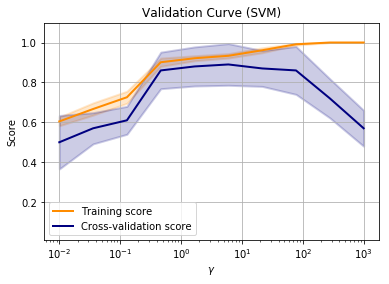

In [9]:
# Plot the results
plt.figure()
lw = 2
plt.semilogx(param_range, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy", lw=lw)

plt.title("Validation Curve (SVM)")
plt.xlabel("$\gamma$")
plt.ylabel("Score")
plt.ylim(0.01, 1.1)
plt.grid()
plt.legend(loc="best")
plt.show()

Now it is clear that the best value for gamma is somewhere around a value of `1-10`.

The beauty is that this works on data of any number of dimensions.

But it does get tricky when you have multiple parameters to tune. For this we have
to perform a _grid search_.

## Learning curves

Another way of visualising performance is with a learning curve.

This plot uses different size samples to perform the training.

If there is a large gap between the train and validation score, then we are overfitting.

If the training score is low, we are underfitting.

If we can see the learning curve continue to rise with more samples, then we might get better
performance if we collected more samples.

### Use

We use the learning curve in a similar way to the validation curve above, but using the module:
`from sklearn.model_selection import learning_curve`.

### Tasks

- Plot the learning curve. You should be able to use similar code as above

In [10]:
# Your code here

In [11]:
from sklearn.datasets import make_moons

# Synthetic data
X, y = make_moons(noise=0.2, random_state=42)

# This is how we split our data, using the `train_test_split` method
X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=.4, random_state=42)

### Bonus tasks

- Fit a Support Vector Machine to the above "moons" data.